<a href="https://colab.research.google.com/github/fatsoengineer/Computer_Vision_Course/blob/master/S5/5th_Model_Layer_restructure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to step 4 [Notebook_4](https://github.com/fatsoengineer/Computer_Vision_Course/blob/master/S5/4th_Model_GAP_Layer.ipynb)
## Step 4

 **Target:**

> Restructure model as the model started fluctuating after adding GAP layer and increasing capacity


**Results**


> 
*   Total params: 6,376
*   Best Test Accuracy: 
```
EPOCH: 10
Loss=0.01986701786518097 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:15<00:00, 59.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]
Test set: Average loss: 0.0260, Accuracy: 9932/10000 (99.32%)
```


**Analysis**

> * Restructured the model to remove a block to increase depth. Removed padding to avoid increasing unnecessary depth. Got better and consistant result.
* Ran multiple times to confirm that the results are not fluke or not fluctuating from each training at large 


# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
from torchsummary import summary

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


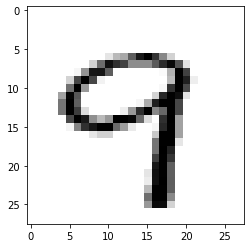

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

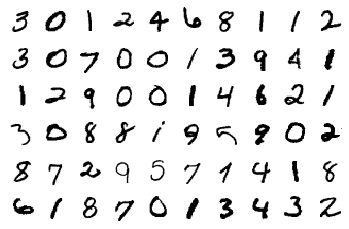

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')


# The model
Let's start with the model we first saw

In [0]:
dropout_value =.10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False), #26
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #24
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            # nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #22
            # nn.BatchNorm2d(12),
            # nn.ReLU(),
            # nn.Dropout(dropout_value),

            nn.MaxPool2d(2,2), # 11
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #9
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), #7
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(dropout_value),
        )

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.reducer = nn.Conv2d(12,10,1,bias=False)

    def forward(self, x):
      x= self.conv1(x)
      x= self.conv2(x)
      x= self.conv3(x)
      x =self.gap(x)
      x= self.reducer(x)
      x = x.view(-1, 10)
      return F.log_softmax(x)

Batch Norm after Relu


In [0]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()

#         self.conv1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(8),

#             nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(12),

#             nn.MaxPool2d(2,2), # 14
#         )

#         self.conv2 = nn.Sequential(
#             nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),

#             nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
#             nn.ReLU(),
#             nn.BatchNorm2d(16),

#             nn.MaxPool2d(2,2), #5
#         )

#         self.conv3 = nn.Sequential(
#             nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),            
#             nn.ReLU(),
#             nn.BatchNorm2d(20),
#         )

#         self.reducer = nn.Conv2d(20,10,3,bias=False)

#     def forward(self, x):
#       x= self.conv1(x)
#       x= self.conv2(x)
#       x= self.conv3(x)
#       x= self.reducer(x)
#       x = x.view(-1, 10)
#       return F.log_softmax(x)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]             864
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
         MaxPool2d-9           [-1, 12, 12, 12]               0
           Conv2d-10           [-1, 12, 10, 10]           1,296
      BatchNorm2d-11           [-1, 12, 10, 10]              24
             ReLU-12           [-1, 12, 10, 10]               0
          Dropout-13           [-1, 12, 10, 10]               0
           Conv2d-14             [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(1,EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.13286486268043518 Batch_id=937 Accuracy=90.45: 100%|██████████| 938/938 [00:15<00:00, 59.05it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0618, Accuracy: 9816/10000 (98.16%)

EPOCH: 2


Loss=0.10927772521972656 Batch_id=937 Accuracy=97.66: 100%|██████████| 938/938 [00:15<00:00, 59.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0446, Accuracy: 9872/10000 (98.72%)

EPOCH: 3


Loss=0.12001895904541016 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:15<00:00, 59.85it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9885/10000 (98.85%)

EPOCH: 4


Loss=0.03954945504665375 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [00:15<00:00, 59.67it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Accuracy: 9890/10000 (98.90%)

EPOCH: 5


Loss=0.004318654537200928 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:15<00:00, 59.57it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9898/10000 (98.98%)

EPOCH: 6


Loss=0.13742394745349884 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:16<00:00, 68.46it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.07262818515300751 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:15<00:00, 58.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9926/10000 (99.26%)

EPOCH: 8


Loss=0.012391969561576843 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:15<00:00, 59.33it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9927/10000 (99.27%)

EPOCH: 9


Loss=0.010019749402999878 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:15<00:00, 59.53it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.01986701786518097 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:15<00:00, 59.50it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.025477662682533264 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:16<00:00, 58.43it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.0013803839683532715 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:15<00:00, 59.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.00110703706741333 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:15<00:00, 67.87it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.004602938890457153 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [00:15<00:00, 59.32it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9928/10000 (99.28%)

EPOCH: 15


Loss=0.08019761741161346 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:15<00:00, 58.78it/s]



Test set: Average loss: 0.0254, Accuracy: 9920/10000 (99.20%)



Text(0.5, 1.0, 'Test Accuracy')

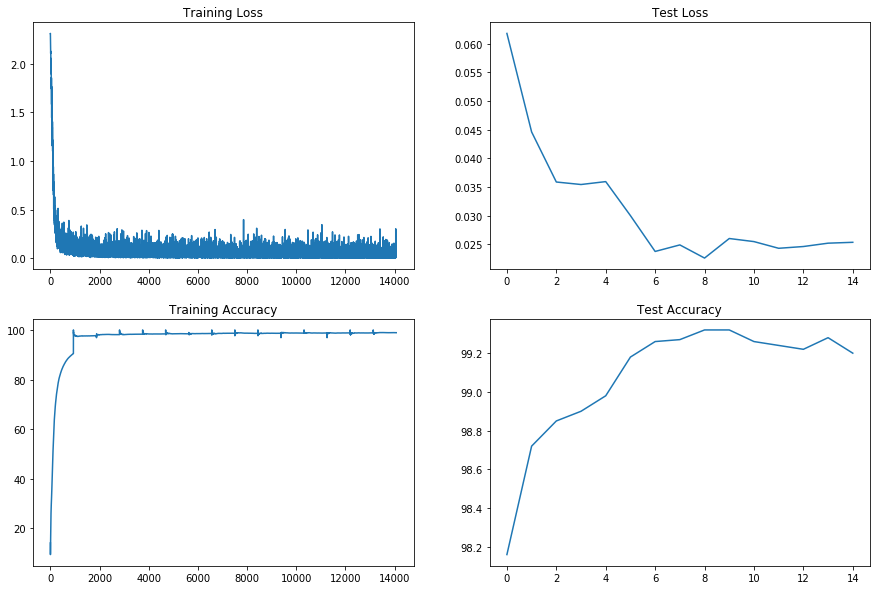

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")